# Machine learning - final project

## 1. The project

The goal of this project is to try to identify "persons of interest" (POI) in the Enron case from the corpus of Enron emails and financial data. Supervised machine learning will be used to teach the machine to recognize new POI from the already known ones.

The dataset consists of a dictionary of all persons in the email corpus, with the known financial (salary, stock, etc.) and email (from and to messages, etc.) data for each of them.

### Data exploration

In [1]:
import sys
import pickle
import matplotlib.pyplot as plt
from pprint import pprint
sys.path.append("../tools/")

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

#### Total number of data points:

In [2]:
print len(data_dict)

146


#### Total number of POI in the dataset:

In [3]:
print len(list(name for name in data_dict.keys() if data_dict[name]["poi"] == 1))

18


#### Number of features used:

In [4]:
features = set()
for name in data_dict.keys():
    for key in data_dict[name].keys():
        features.add(key)

print len(features)
print features

21
set(['salary', 'to_messages', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'email_address', 'restricted_stock_deferred', 'total_stock_value', 'shared_receipt_with_poi', 'long_term_incentive', 'exercised_stock_options', 'from_messages', 'other', 'from_poi_to_this_person', 'from_this_person_to_poi', 'poi', 'deferred_income', 'expenses', 'restricted_stock', 'director_fees'])


#### Number of missing values (`NaN`) for each feature:

In [5]:
missing_values = {}
for feature in features:
    missing_values[feature] = len(list(name for name in data_dict.keys() 
                                       if data_dict[name][feature] == 'NaN'))
    
for feature, n in sorted(missing_values.iteritems(), 
                         key=lambda (k, v): (v, k), reverse=True):
    print feature, n

loan_advances 142
director_fees 129
restricted_stock_deferred 128
deferral_payments 107
deferred_income 97
long_term_incentive 80
bonus 64
to_messages 60
shared_receipt_with_poi 60
from_this_person_to_poi 60
from_poi_to_this_person 60
from_messages 60
other 53
salary 51
expenses 51
exercised_stock_options 44
restricted_stock 36
email_address 35
total_payments 21
total_stock_value 20
poi 0


Only `poi` has no missing value.

#### Number of values equal to zero for each feature:

In [6]:
zero_values = {}
for feature in features:
    zero_values[feature] = len(list(name for name in data_dict.keys() 
                                    if data_dict[name][feature] == 0))
    
for feature, n in sorted(zero_values.iteritems(), 
                         key=lambda (k, v): (v, k), reverse=True):
    print feature, n

poi 128
from_this_person_to_poi 20
from_poi_to_this_person 12
total_stock_value 0
total_payments 0
to_messages 0
shared_receipt_with_poi 0
salary 0
restricted_stock_deferred 0
restricted_stock 0
other 0
long_term_incentive 0
loan_advances 0
from_messages 0
expenses 0
exercised_stock_options 0
email_address 0
director_fees 0
deferred_income 0
deferral_payments 0
bonus 0


Only `from_this_person_to_poi` and `from_poi_to_this_person` have both `NaN` and 0 values. For all other features we can replace `NaN` with 0 without introducing any ambiguity.

##### Replacement of `NaN` by 0 for all features except `poi`, `from_this_person_to_poi ` and `from_poi_to_this_person`:

In [7]:
for feature in features:
    if zero_values[feature] == 0 and not feature =='email_address':
        for name in data_dict.keys():
            if data_dict[name][feature] == 'NaN':
                data_dict[name][feature] = 0
        
zero_values = {}
for feature in features:
    zero_values[feature] = len(list(name for name in data_dict.keys() 
                                    if data_dict[name][feature] == 0))
    
for feature, n in sorted(zero_values.iteritems(), 
                         key=lambda (k, v): (v, k), reverse=True):
    print feature, n

loan_advances 142
director_fees 129
restricted_stock_deferred 128
poi 128
deferral_payments 107
deferred_income 97
long_term_incentive 80
bonus 64
to_messages 60
shared_receipt_with_poi 60
from_messages 60
other 53
salary 51
expenses 51
exercised_stock_options 44
restricted_stock 36
total_payments 21
total_stock_value 20
from_this_person_to_poi 20
from_poi_to_this_person 12
email_address 0


We have the expected number of zeroes for each feature.

### Outlier investigation

We will first plot bonus versus salary and examine the output for any weird values:

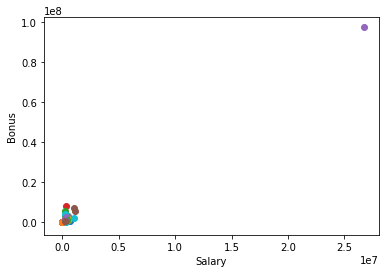

In [8]:
for record in data_dict.items():
    salary = record[1]['salary']
    bonus = record[1]['bonus']
    plt.scatter( salary, bonus )

plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.show()

There is a suspiciously outlying data point. Let us see what record it belongs to:

In [9]:
pprint (max(data_dict.items(), key=lambda record: float(record[1]['salary'])))

('TOTAL',
 {'bonus': 97343619,
  'deferral_payments': 32083396,
  'deferred_income': -27992891,
  'director_fees': 1398517,
  'email_address': 'NaN',
  'exercised_stock_options': 311764000,
  'expenses': 5235198,
  'from_messages': 0,
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 83925000,
  'long_term_incentive': 48521928,
  'other': 42667589,
  'poi': False,
  'restricted_stock': 130322299,
  'restricted_stock_deferred': -7576788,
  'salary': 26704229,
  'shared_receipt_with_poi': 0,
  'to_messages': 0,
  'total_payments': 309886585,
  'total_stock_value': 434509511})


This is not a valid data point but the total of all numerical values. It should be discarded:

In [10]:
data_dict.pop('TOTAL')

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 0,
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 0,
 'to_messages': 0,
 'total_payments': 309886585,
 'total_stock_value': 434509511}

Let us now check what the chart looks like without the totals:

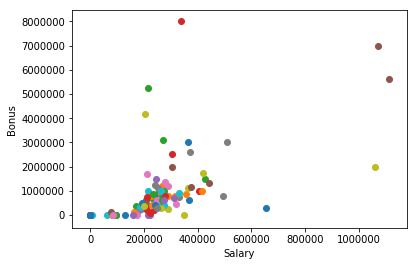

In [11]:
for record in data_dict.items():
    salary = record[1]['salary']
    bonus = record[1]['bonus']
    plt.scatter(salary, bonus)

plt.xlabel("Salary")
plt.ylabel("Bonus")
plt.show()

This looks better, but four data points (the highest bonus and the three highest salaries) still look suspicious. We will examine them:

In [12]:
pprint (max(data_dict.items(), key=lambda record: float(record[1]['bonus'])))
print
pprint (sorted(data_dict.items(), key=lambda record: float(record[1]['salary']), 
               reverse=True)[:3])

('LAVORATO JOHN J',
 {'bonus': 8000000,
  'deferral_payments': 0,
  'deferred_income': 0,
  'director_fees': 0,
  'email_address': 'john.lavorato@enron.com',
  'exercised_stock_options': 4158995,
  'expenses': 49537,
  'from_messages': 2585,
  'from_poi_to_this_person': 528,
  'from_this_person_to_poi': 411,
  'loan_advances': 0,
  'long_term_incentive': 2035380,
  'other': 1552,
  'poi': False,
  'restricted_stock': 1008149,
  'restricted_stock_deferred': 0,
  'salary': 339288,
  'shared_receipt_with_poi': 3962,
  'to_messages': 7259,
  'total_payments': 10425757,
  'total_stock_value': 5167144})

[('SKILLING JEFFREY K',
  {'bonus': 5600000,
   'deferral_payments': 0,
   'deferred_income': 0,
   'director_fees': 0,
   'email_address': 'jeff.skilling@enron.com',
   'exercised_stock_options': 19250000,
   'expenses': 29336,
   'from_messages': 108,
   'from_poi_to_this_person': 88,
   'from_this_person_to_poi': 30,
   'loan_advances': 0,
   'long_term_incentive': 1920000,
   'other': 22

These data look legitimate as these persons were among Enron's top management, and thus were expected to receive some of the highest salaries and / or bonuses.

##### Comparing total_payments to the sum of all known payments:
As there are two features called "total" (total_payments and total_stock_value) we will make a sanity check for erroneous sums.

BELFER ROBERT 102500 -99215
BHATNAGAR SANJAY 15456290 275728


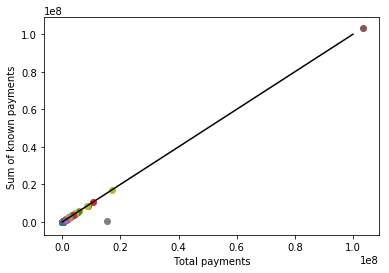

In [13]:
sum_different_from_total = []

for record in data_dict.items():
    total_payments = record[1]['total_payments']
    sum_known_payments = record[1]['bonus'] + \
                        record[1]['deferral_payments'] + \
                        record[1]['director_fees'] + \
                        record[1]['expenses'] + \
                        record[1]['loan_advances'] + \
                        record[1]['long_term_incentive'] + \
                        record[1]['other'] + \
                        record[1]['salary'] + \
                        record[1]['deferred_income']
                        
    if sum_known_payments <> total_payments:
        sum_different_from_total.append(record)
        print record[0], total_payments, sum_known_payments
    
    plt.scatter(total_payments, sum_known_payments)

plt.plot([0, 1e8], [0, 1e8], color='k')
plt.xlabel("Total payments")
plt.ylabel("Sum of known payments")
plt.show()

Two records have wrong total payments and will be discarded. The plot shows an outlier with a much higher total payment than all others. Let us see whom it belongs to:

In [14]:
pprint (max(data_dict.items(), key=lambda record: 
            float(record[1]['total_payments'])))

('LAY KENNETH L',
 {'bonus': 7000000,
  'deferral_payments': 202911,
  'deferred_income': -300000,
  'director_fees': 0,
  'email_address': 'kenneth.lay@enron.com',
  'exercised_stock_options': 34348384,
  'expenses': 99832,
  'from_messages': 36,
  'from_poi_to_this_person': 123,
  'from_this_person_to_poi': 16,
  'loan_advances': 81525000,
  'long_term_incentive': 3600000,
  'other': 10359729,
  'poi': True,
  'restricted_stock': 14761694,
  'restricted_stock_deferred': 0,
  'salary': 1072321,
  'shared_receipt_with_poi': 2411,
  'to_messages': 4273,
  'total_payments': 103559793,
  'total_stock_value': 49110078})


It is no surprise that Kenneth Lay, founder, CEO and Chairman of Enron Corporation for most of its existence got the highest total payments. We will therefore keep this data point.

##### Stock features:

BELFER ROBERT -44093 47378
BHATNAGAR SANJAY 0 15456290


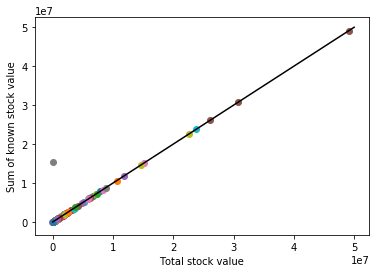

In [15]:
sum_different_from_total = []

for record in data_dict.items():
    total_stock_value = record[1]['total_stock_value']
    sum_known_stock_value = record[1]['exercised_stock_options'] + \
                            record[1]['restricted_stock'] + \
                            record[1]['restricted_stock_deferred']
                        
    if sum_known_stock_value <> total_stock_value:
        sum_different_from_total.append(record)
        print record[0], total_stock_value, sum_known_stock_value
    
    plt.scatter(total_stock_value, sum_known_stock_value)

plt.plot([0, 5e7], [0, 5e7], color='k')
plt.xlabel("Total stock value")
plt.ylabel("Sum of known stock value")
plt.show()

The same two persons also have wrong total stock value. There is, however, no suspicious point in this chart.

We can discard these two records:

In [16]:
print data_dict['BELFER ROBERT']

{'salary': 0, 'to_messages': 0, 'deferral_payments': -102500, 'total_payments': 102500, 'exercised_stock_options': 3285, 'bonus': 0, 'restricted_stock': 0, 'shared_receipt_with_poi': 0, 'restricted_stock_deferred': 44093, 'total_stock_value': -44093, 'expenses': 0, 'loan_advances': 0, 'from_messages': 0, 'other': 0, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 3285, 'deferred_income': 0, 'long_term_incentive': 0, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}


In [17]:
print data_dict['BHATNAGAR SANJAY']

{'salary': 0, 'to_messages': 523, 'deferral_payments': 0, 'total_payments': 15456290, 'exercised_stock_options': 2604490, 'bonus': 0, 'restricted_stock': -2604490, 'shared_receipt_with_poi': 463, 'restricted_stock_deferred': 15456290, 'total_stock_value': 0, 'expenses': 0, 'loan_advances': 0, 'from_messages': 29, 'other': 137864, 'from_this_person_to_poi': 1, 'poi': False, 'director_fees': 137864, 'deferred_income': 0, 'long_term_incentive': 0, 'email_address': 'sanjay.bhatnagar@enron.com', 'from_poi_to_this_person': 0}


In [18]:
data_dict.pop('BELFER ROBERT')
data_dict.pop('BHATNAGAR SANJAY')

{'bonus': 0,
 'deferral_payments': 0,
 'deferred_income': 0,
 'director_fees': 137864,
 'email_address': 'sanjay.bhatnagar@enron.com',
 'exercised_stock_options': 2604490,
 'expenses': 0,
 'from_messages': 29,
 'from_poi_to_this_person': 0,
 'from_this_person_to_poi': 1,
 'loan_advances': 0,
 'long_term_incentive': 0,
 'other': 137864,
 'poi': False,
 'restricted_stock': -2604490,
 'restricted_stock_deferred': 15456290,
 'salary': 0,
 'shared_receipt_with_poi': 463,
 'to_messages': 523,
 'total_payments': 15456290,
 'total_stock_value': 0}

## 2. Feature selection and engineering

### Feature selection

From the available set of features we will try to extract the most useful ones. We will use for this purpose the `SelectKBest` function:

In [19]:
from feature_format import featureFormat, targetFeatureSplit

features_list = ['poi', 'salary', 'deferral_payments', 'total_payments', 
                 'loan_advances', 'bonus', 'restricted_stock_deferred', 
                 'deferred_income', 'total_stock_value', 'expenses', 
                 'exercised_stock_options', 'other', 'long_term_incentive', 
                 'restricted_stock', 'director_fees', 'to_messages', 
                 'from_poi_to_this_person', 'from_messages', 
                 'from_this_person_to_poi', 'shared_receipt_with_poi']

data = featureFormat(data_dict, features_list)
labels, features = targetFeatureSplit(data)

from sklearn.feature_selection import SelectKBest

k_best = SelectKBest(k=5)
selected_features = k_best.fit_transform(features, labels)

pprint (sorted(zip(k_best.scores_, features_list[1:]), reverse=True))

[(24.714052256343795, 'exercised_stock_options'),
 (23.896807476321385, 'total_stock_value'),
 (20.524645181851792, 'bonus'),
 (18.003739993113935, 'salary'),
 (11.321486775141238, 'deferred_income'),
 (9.772103538408254, 'long_term_incentive'),
 (9.17556940305799, 'total_payments'),
 (8.99886174843595, 'restricted_stock'),
 (8.495111177152825, 'shared_receipt_with_poi'),
 (7.1253824688830685, 'loan_advances'),
 (5.954544292197293, 'expenses'),
 (5.14221919450697, 'from_poi_to_this_person'),
 (4.1028045216285225, 'other'),
 (2.3399524507556366, 'from_this_person_to_poi'),
 (1.9723088299289142, 'director_fees'),
 (1.6109754038652737, 'to_messages'),
 (0.8499660035977262, 'restricted_stock_deferred'),
 (0.23671093690118508, 'deferral_payments'),
 (0.17484071858227693, 'from_messages')]


The list above shows the score of each feature in the dataset, sorted in descending order. The four highest scores are much higher than the following ones (18 to 24 versus only 11 for the fifth highest score), which induces us to select the corresponding features.

Let us calculate the scores of a simple tree classifier with all features, and then with only the 5, 4 and 3 best features. Each score will be averaged over three runs.

In [20]:
from sklearn import model_selection, tree
import numpy as np

np.random.seed(42) # re-seed each time the cell is run without kernel restart
features_train, features_test, labels_train, labels_test = \
            model_selection.train_test_split(features, labels, test_size=.3, 
                                             random_state=42)

#### All features:

This is the baseline to which we will compare other feature selections.

In [21]:
np.random.seed(42)
score = np.array([])

kf = model_selection.KFold(n_splits=3, random_state=42)
for train_index, test_index in kf.split(features):
    features_train = np.array(features)[train_index]
    features_test = np.array(features)[test_index]
    labels_train = np.array(labels)[train_index]
    labels_test = np.array(labels)[test_index]

    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(features_train, labels_train)

    score = np.append(score, [clf.score (features_test, labels_test)])
    
print np.average(score)

0.7600472813238771


#### 5 best features:

In [22]:
np.random.seed(42)
score = np.array([])

k_best = SelectKBest(k=5)
selected_features = k_best.fit_transform(features, labels)

kf = model_selection.KFold(n_splits=3, random_state=42)
for train_index, test_index in kf.split(selected_features):
    features_train = selected_features[train_index]
    features_test = selected_features[test_index]
    labels_train = np.array(labels)[train_index]
    labels_test = np.array(labels)[test_index]

    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(features_train, labels_train)

    score = np.append(score, [clf.score (features_test, labels_test)])
    
print np.average(score)

0.7607860520094563


#### 4 best features:

In [23]:
np.random.seed(42)
score = np.array([])

k_best = SelectKBest(k=4)
selected_features = k_best.fit_transform(features, labels)

kf = model_selection.KFold(n_splits=3, random_state=42)
for train_index, test_index in kf.split(selected_features):
    features_train = selected_features[train_index]
    features_test = selected_features[test_index]
    labels_train = np.array(labels)[train_index]
    labels_test = np.array(labels)[test_index]

    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(features_train, labels_train)

    score = np.append(score, [clf.score (features_test, labels_test)])
    
print np.average(score)

0.8101359338061466


#### 3 best features:

In [24]:
np.random.seed(42)
score = np.array([])

k_best = SelectKBest(k=3)
selected_features = k_best.fit_transform(features, labels)

kf = model_selection.KFold(n_splits=3, random_state=42)
for train_index, test_index in kf.split(selected_features):
    features_train = selected_features[train_index]
    features_test = selected_features[test_index]
    labels_train = np.array(labels)[train_index]
    labels_test = np.array(labels)[test_index]

    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(features_train, labels_train)

    score = np.append(score, [clf.score (features_test, labels_test)])
    
print np.average(score)

0.7958037825059101


The highest score is obtained with four features: `exercised_stock_options`, `total_stock_value`, `bonus` and `salary`.

### Creating a new feature: total_stock_value / total_payments

We will first investigate the creation of a feature measuring the ratio of total stock value over total payments. The rationale behind this is that POIs might have wanted to pay themselves in stock, the value of which they effectively manipulated, rather than in salary.

In [25]:
index_total_payments = features_list[1:].index('total_payments')
index_total_stock_value = features_list[1:].index('total_stock_value')

for i in range(len(features)):
    if features[i][index_total_payments] > 0:
        features[i] = np.append(features[i][:19], 
                                [features[i][index_total_stock_value] / 
                                 features[i][index_total_payments]])
    else:
        features[i] = np.append(features[i][:19], [0])

Here is what a plot of the new feature versus total payments looks like:

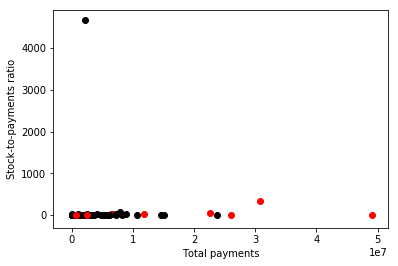

In [26]:
for i in range(len(features)):
    if labels[i] == 1:
        c = 'r'
    else:
        c = 'k'
    plt.scatter(features[i][index_total_stock_value], features[i][-1], color=c)

plt.xlabel("Total payments")
plt.ylabel("Stock-to-payments ratio")
plt.show()

Red points are POI and black are non-POI. We notice an outlier with a very high ratio:

In [27]:
for i in range(len(features)):
    if features[i][-1] > 4000:
        pprint (data_dict.items()[i])

('HAUG DAVID L',
 {'bonus': 0,
  'deferral_payments': 0,
  'deferred_income': 0,
  'director_fees': 0,
  'email_address': 'david.haug@enron.com',
  'exercised_stock_options': 0,
  'expenses': 475,
  'from_messages': 19,
  'from_poi_to_this_person': 4,
  'from_this_person_to_poi': 7,
  'loan_advances': 0,
  'long_term_incentive': 0,
  'other': 0,
  'poi': False,
  'restricted_stock': 2217299,
  'restricted_stock_deferred': 0,
  'salary': 0,
  'shared_receipt_with_poi': 471,
  'to_messages': 573,
  'total_payments': 475,
  'total_stock_value': 2217299})


There does not seem to be any error here, this is a person who held significant Enron stock without receiving a salary from Enron. If we limit the graph to the other data point we get:

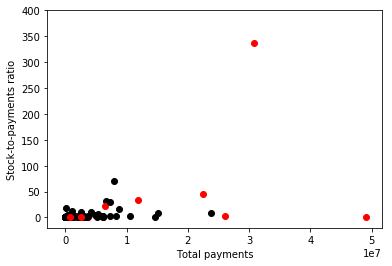

In [28]:
for i in range(len(features)):
    if labels[i] == 1:
        c = 'r'
    else:
        c = 'k'
    plt.scatter(features[i][index_total_stock_value], features[i][-1], color=c)

plt.xlabel("Total payments")
plt.ylabel("Stock-to-payments ratio")
plt.ylim(-20, 400)
plt.show()

There is still one outlier:

In [29]:
for i in range(len(features)):
    if  features[i][-1] > 200 and features[i][-1] < 4000:
        pprint (data_dict.items()[i])

('YEAGER F SCOTT',
 {'bonus': 0,
  'deferral_payments': 0,
  'deferred_income': 0,
  'director_fees': 0,
  'email_address': 'scott.yeager@enron.com',
  'exercised_stock_options': 8308552,
  'expenses': 53947,
  'from_messages': 0,
  'from_poi_to_this_person': 'NaN',
  'from_this_person_to_poi': 'NaN',
  'loan_advances': 0,
  'long_term_incentive': 0,
  'other': 147950,
  'poi': True,
  'restricted_stock': 3576206,
  'restricted_stock_deferred': 0,
  'salary': 158403,
  'shared_receipt_with_poi': 0,
  'to_messages': 0,
  'total_payments': 360300,
  'total_stock_value': 11884758})


which looks valid.

#### Evaluation of the `stock_payment_ratio` feature:

In [30]:
k_best = SelectKBest(k=4)
selected_features = k_best.fit_transform(features, labels)

pprint (sorted(zip(k_best.scores_, features_list[1:] + ['stock_payment_ratio']), 
               reverse=True))

[(24.714052256343795, 'exercised_stock_options'),
 (23.896807476321385, 'total_stock_value'),
 (20.524645181851792, 'bonus'),
 (18.003739993113935, 'salary'),
 (11.321486775141238, 'deferred_income'),
 (9.772103538408254, 'long_term_incentive'),
 (9.17556940305799, 'total_payments'),
 (8.99886174843595, 'restricted_stock'),
 (8.495111177152825, 'shared_receipt_with_poi'),
 (7.1253824688830685, 'loan_advances'),
 (5.954544292197293, 'expenses'),
 (5.14221919450697, 'from_poi_to_this_person'),
 (4.1028045216285225, 'other'),
 (2.3399524507556366, 'from_this_person_to_poi'),
 (1.9723088299289142, 'director_fees'),
 (1.6109754038652737, 'to_messages'),
 (0.8499660035977262, 'restricted_stock_deferred'),
 (0.23671093690118508, 'deferral_payments'),
 (0.17484071858227693, 'from_messages'),
 (0.023632508525664474, 'stock_payment_ratio')]


Obviously this new feature performs quite badly, as it gets by far the worst score!

Let us therefore try to create a better feature.

### Creating a new feature: total_stock_value + total_payments

We will create a total of all finance features, representing an estimate of the total amount of money earned, in one form or another, from the operations of the Enron company.

In [31]:
for i in range(len(features)):
    if features[i][index_total_payments] > 0 and \
                            features[i][index_total_stock_value] > 0:
        features[i] = np.append(features[i][:19], 
                                [features[i][index_total_stock_value] + 
                                 features[i][index_total_payments]])
    else:
        features[i] = np.append(features[i][:19], [0])

If we plot this new feature against total payments we get only one outlier:

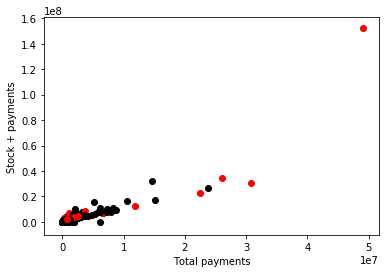

In [32]:
for i in range(len(features)):
    if labels[i] == 1:
        c = 'r'
    else:
        c = 'k'
    plt.scatter(features[i][index_total_stock_value], features[i][-1], color=c)

plt.xlabel("Total payments")
plt.ylabel("Stock + payments")
plt.show()

In [33]:
for i in range(len(features)):
    if features[i][-1] > 1E8:
        print data_dict.items()[i]

('LAY KENNETH L', {'salary': 1072321, 'to_messages': 4273, 'deferral_payments': 202911, 'total_payments': 103559793, 'exercised_stock_options': 34348384, 'bonus': 7000000, 'restricted_stock': 14761694, 'shared_receipt_with_poi': 2411, 'restricted_stock_deferred': 0, 'total_stock_value': 49110078, 'expenses': 99832, 'loan_advances': 81525000, 'from_messages': 36, 'other': 10359729, 'from_this_person_to_poi': 16, 'poi': True, 'director_fees': 0, 'deferred_income': -300000, 'long_term_incentive': 3600000, 'email_address': 'kenneth.lay@enron.com', 'from_poi_to_this_person': 123})


The outlier is Kenneth Lay himself, which makes sense. We are keeping this data point.

Let us run `SelectKBest` to score the new feature:

In [34]:
k_best = SelectKBest(k=5)
selected_features = k_best.fit_transform(features, labels)

pprint (sorted(zip(k_best.scores_, features_list[1:] + ['stock_plus_payments']), 
               reverse=True))

[(24.714052256343795, 'exercised_stock_options'),
 (23.896807476321385, 'total_stock_value'),
 (20.524645181851792, 'bonus'),
 (18.003739993113935, 'salary'),
 (17.607795269045265, 'stock_plus_payments'),
 (11.321486775141238, 'deferred_income'),
 (9.772103538408254, 'long_term_incentive'),
 (9.17556940305799, 'total_payments'),
 (8.99886174843595, 'restricted_stock'),
 (8.495111177152825, 'shared_receipt_with_poi'),
 (7.1253824688830685, 'loan_advances'),
 (5.954544292197293, 'expenses'),
 (5.14221919450697, 'from_poi_to_this_person'),
 (4.1028045216285225, 'other'),
 (2.3399524507556366, 'from_this_person_to_poi'),
 (1.9723088299289142, 'director_fees'),
 (1.6109754038652737, 'to_messages'),
 (0.8499660035977262, 'restricted_stock_deferred'),
 (0.23671093690118508, 'deferral_payments'),
 (0.17484071858227693, 'from_messages')]


This feature achieves the fifth best score, almost equal to the score of `salary`. Let us now submit it to the test of the tree classifier, as was done earlier for the first for best features:

In [35]:
np.random.seed(42)
score = np.array([])

kf = model_selection.KFold(n_splits=3, random_state=42)
for train_index, test_index in kf.split(selected_features):
    features_train = selected_features[train_index]
    features_test = selected_features[test_index]
    labels_train = np.array(labels)[train_index]
    labels_test = np.array(labels)[test_index]

    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(features_train, labels_train)

    score = np.append(score, [clf.score (features_test, labels_test)])
    
print np.average(score)

0.8312647754137116


This is the best score so far, we will therefore keep the new feature `stock_plus_payments` in our feature list.

In [36]:
features_list = ['poi', 'salary', 'bonus', 'total_stock_value', 'total_payments']

my_dataset = data_dict

for name in my_dataset:
    if my_dataset[name]['total_payments'] > 0 and \
                my_dataset[name]['total_stock_value'] > 0:
        my_dataset[name]['stock_plus_payments'] = \
                    my_dataset[name]['total_payments'] + \
                    my_dataset[name]['total_stock_value']
    else:
        my_dataset[name]['stock_plus_payments'] = 0

features_list.append('stock_plus_payments')

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

#### Final selection

The final selection of features is `poi`, `salary`, `bonus`, `total_stock_value` and `total_payments`. As these are all "finance" features expressed in USD and it is important to capture the possible differences in magnitude, we will not use scaling.

## 3. Algorithm selection

The selected algorithm is `DecisionTreeClassifier`.

The other ones that were tried are `LinearSVC`, `KNeighborsClassifier`, `GaussianNB` and `RandomForestClassifier`. All were evaluated against the `test_classifier` function from `tester.py` (implemented below) which calculates the average precision and recall over 1000 folds of `StratifiedShuffleSplit`.

Over the tests performed, we were able to reach 0.3 for both precision and recall with `DecisionTreeClassifier` only. With all classifiers we tried, only one of the values (either precision or recall) ever reached 0.3. The table below summarizes the performance differences for the best results we got with each algorithm:

| Algorithm              | Precision | Recall  |
|:-----------------------|----------:|--------:|
| DecisionTreeClassifier | 0.37101   | 0.33150 |
| LinearSVC              | 0.18300   | 0.48000 |
| KNeighborsClassifier   | 0.30968   | 0.24000 |
| GaussianNB             | 0.53039   | 0.28800 |
| RandomForestClassifier | 0.37707   | 0.13650 |

In [37]:
PERF_FORMAT_STRING = "\
\tAccuracy: {:>0.{display_precision}f}\tPrecision: {:>0.{display_precision}f}\t\
Recall: {:>0.{display_precision}f}\tF1: {:>0.{display_precision}f}\tF2: {:>0.{display_precision}f}"
RESULTS_FORMAT_STRING = "\tTotal predictions: {:4d}\tTrue positives: {:4d}\tFalse positives: {:4d}\
\tFalse negatives: {:4d}\tTrue negatives: {:4d}"

def test_classifier(clf, dataset, feature_list, folds = 1000):
    data = featureFormat(dataset, feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    cv = model_selection.StratifiedShuffleSplit(folds, random_state = 42)
    true_negatives = 0
    false_negatives = 0
    true_positives = 0
    false_positives = 0
    
    for train_idx, test_idx in cv.split(features, labels): 
        features_train = []
        features_test  = []
        labels_train   = []
        labels_test    = []
        for ii in train_idx:
            features_train.append( features[ii] )
            labels_train.append( labels[ii] )
        for jj in test_idx:
            features_test.append( features[jj] )
            labels_test.append( labels[jj] )
        
        ### fit the classifier using training set, and test on test set
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        for prediction, truth in zip(predictions, labels_test):
            if prediction == 0 and truth == 0:
                true_negatives += 1
            elif prediction == 0 and truth == 1:
                false_negatives += 1
            elif prediction == 1 and truth == 0:
                false_positives += 1
            elif prediction == 1 and truth == 1:
                true_positives += 1
            else:
                print "Warning: Found a predicted label not == 0 or 1."
                print "All predictions should take value 0 or 1."
                print "Evaluating performance for processed predictions:"
                break
    
    try:
        total_predictions = true_negatives + false_negatives + false_positives + true_positives
        accuracy = 1.0*(true_positives + true_negatives)/total_predictions
        precision = 1.0*true_positives/(true_positives+false_positives)
        recall = 1.0*true_positives/(true_positives+false_negatives)
        f1 = 2.0 * true_positives/(2*true_positives + false_positives+false_negatives)
        f2 = (1+2.0*2.0) * precision*recall/(4*precision + recall)
        print clf
        print PERF_FORMAT_STRING.format(accuracy, precision, recall, f1, f2, display_precision = 5)
        print RESULTS_FORMAT_STRING.format(total_predictions, true_positives, false_positives, false_negatives, true_negatives)
        print ""
    except:
        print "Got a divide by zero when trying out:", clf
        print "Precision or recall may be undefined due to a lack of true positive predictions."


## 4. Parameter tuning

Many algorithms have parameters that you need to set. These parameters, depending on the particular algorithm, can be a number of runs, a maximum number of output elements, a way of weighting results or anything relevant. They can have a dramatic effect on th quality of the classification and need to be tuned accurately.

We used the `GridSearchCV` function to automatically test multiple parameter combinations and select the best one. The tuned parameters were `criterion`, `max_depth` and `class_weight`. Their optimization yielded the default values except for `max_depth` which ended up at 50.

In [38]:
from sklearn import tree

np.random.seed(42)
parameters = {'criterion':('gini', 'entropy'), 'max_depth':(10, 50, 100, None), 
              'class_weight':('balanced', None)}
svr = tree.DecisionTreeClassifier()
clf = model_selection.GridSearchCV(svr, parameters, cv=10, 
                                   scoring=['precision', 'recall', 'f1'], 
                                   refit='precision', n_jobs=-1, verbose=1)
clf.fit(features, labels)

test_classifier(clf.best_estimator_, my_dataset, features_list)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.6s finished


DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.82421	Precision: 0.37101	Recall: 0.33150	F1: 0.35015	F2: 0.33871
	Total predictions: 14000	True positives:  663	False positives: 1124	False negatives: 1337	True negatives: 10876



## 5. Validation

Validation consists in testing the machine learning algorithm on a different dataset than the one used for training. This helps prevent overfitting.

A classic mistake is, when splitting the original dataset into a training and a testing subsets, to select data points which are not independent. For instance, in the present problem, we could have unknowingly built a training dataset containing mostly POI whereas the testing dataset contained very few.

A way to avoid this is, when possible, to shuffle the dataset when splitting it and to validate on several folds.

## 6. Metrics

The performance of our algorithm has been evaluated through precision and recall.

- Precision is the proportion of correctly reported results among all returned results. Precision gives the probablility for a returned result to be correct (for instance: if our algorithm marks somebody as POI, what probability do we have that that person is really a POI?)
- Recall is the proportion of correctly reported results compared to all possible results. Recall gives the probability of finding an existing feature (In our case: how likely is it that our algorithm finds a POI?)

Our algorithm yields a precision of 0.37101 and a recall of 0.33150.